In [6]:
import numpy as np
import matplotlib.pyplot as plt

from engine import Linear, ReLU, Embedding, Flatten, SoftmaxCrossEntropy, MLP

%matplotlib inline

In [7]:
class TinyShakespeareDataset:
    def __init__(self, path, batch_size, seq_len):
        with open(path, "r") as file:
            self.text = file.read()
        
        self.chars = sorted(list(set(self.text)))
        self.vocab_size = len(self.chars)
        self.stoi = {ch:i for i, ch in enumerate(self.chars)}
        self.itos = {i:ch for i, ch in enumerate(self.chars)}
        
        self.data = np.array([self.stoi[ch] for ch in self.text])
        
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.dataset_size = len(self.data)
        
    def get_batch(self):
        # Pick indices from 0 to dataset_size - seq_len - 1 to be sure we have enough space
        ix = np.random.randint(0, self.dataset_size - self.seq_len - 1, (self.batch_size,))
        
        x_batch = []
        y_batch = []
        
        for i in ix: # for starting index out of batch_size:
            x_batch.append(self.data[i : i+self.seq_len])
            y_batch.append(self.data[i + self.seq_len])
            
        return np.array(x_batch), np.array(y_batch) # Results in (B, seq_len) and (B)

In [8]:
def one_hot_enc(y, num_classes):
    y_enc = np.zeros((y.size, num_classes))
    y_enc[np.arange(y.size), y] = 1
    
    return y_enc

In [9]:
def softmax(logits): # We use the same trick as in engine.py SoftmaxCrossEntropy
    max_logits = np.max(logits, axis=1, keepdims=True) # (B, 1)
    shifted_logits = logits - max_logits # (B, vocab_size) where maximum value is 0
    
    logits_exp = np.exp(shifted_logits)
    exp_sum = np.sum(logits_exp, axis=1, keepdims=True) # (B, 1)
    probs = logits_exp / exp_sum # (B, vocab_size), for sampling its (1, vocab_size)
    
    return probs.ravel() # We need a flat array for random.choice -> (vocab_size,)

def sample(model, dataset, start_str=".", max_length=200):
    context = [dataset.stoi.get(c, 0) for c in start_str] # Guards against letters not in vocab
    
    if len(context) < dataset.seq_len:
        padding = [dataset.stoi[' '] for i in range(dataset.seq_len - len(context))] # add padding to be sure we pass seq_len chars (even dummy)
        context = padding + context
        
    sampled_text = start_str # Start here, so we dont see spaces in the output even though they are in context
    
    for _ in range(max_length):
        input_window = context[-dataset.seq_len:] # Get last seq_len of context
        
        x = np.array(input_window).reshape(1, -1) # Batch of 1
        
        logits = model.forward(x)
        probs = softmax(logits)
        
        next_ix = np.random.choice(len(probs), p=probs) # sample based on probability distribution (gives index and uses probs as weights)
        # np.random.choice(a, p) treats: a as items to choose if array, or as a range if integer (our case)
        # In our case it does: pick one from range(0, len(probs)) based on weights of p (return index from p which results in correct value in range under this index)
        
        next_char = dataset.itos[next_ix]
        sampled_text += next_char
        
        context.append(next_ix)
    
    return sampled_text
        
        
    
    

Step: 0 | Loss: 33.4594
This is !G fohnGBUohnG!UgheGlJ;&cUqe-Uhe-chh&Plnn-!&&lcQqqUnhnyPTAGD&nhhY&JmGhGfl-e.G-n &e cheq.GeC.GnWBheTcDhZ&vJ!.mQuqexe3c3cCyn-!ysTcQU&-DB.Jh-!nn-G&J;Yhlnnlql&-cyA& U!n-nhq.pTA
!TqU!
&!hnh!&PgC
c!Tn
!To.D
Step: 500 | Loss: 4.1503
This is boelitotatp hedoM sw
iEtsoE
 AibeEi
hNns  OK,osr&IlBrcp eo   re   he $s$SsIiPTuTl K ZG t
gH:sn:Esl
!hFGAL!k:w s & e &op,!ed:GeaXYELEmR hh-r ohlmWth ibr KVe
I' war Yft ,lt' Jb,IZeZGvY!Ew:
OlgaJ
;IUmdo 
Step: 1000 | Loss: 3.0940
This is & 'NNIp:;:SfyKhou m quynss Z,sdr RATe a,
he JuIiLelo' cr wg pfl 
UetAhcyl B O Noh N see aLCawiC'h et foa
ri.Y AfoPr
y k quEne
hiyuuS staheda? theuXgPocBRDh::Fsopiu
ra es iJl;MTBG J
; Tmo,iPos coneL,eD
Step: 1500 | Loss: 2.6808
This is  ahonenxe
!rtRuthonnriGiyoEegraLP
EreBDzd$s:
eOhkErn:
Th ?uripVac,Elf aasoa , san,  & FnNed .,
yoho ' Iu nos :
biO ,etwe OBen 
 micboltlo 3,PeRWrpEtu
Flitoet  wahot;
co
Wofayeecoti-reihu woe
,
Me C ga
Step: 2000 | Loss: 2.6616
This is tos
d en heeruame paTSi
es, M

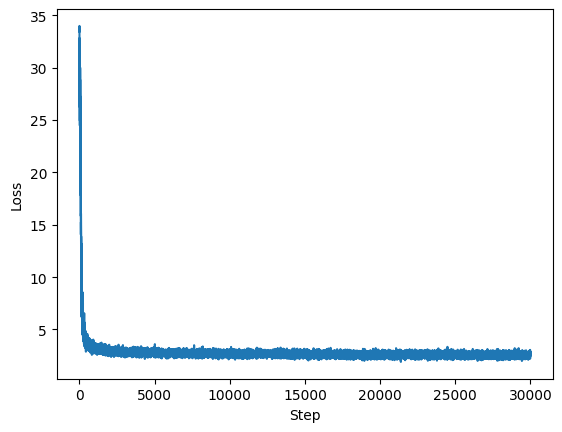

In [ ]:
max_steps = 30000
batch_size = 64
seq_len = 8
learning_rate = 2e-2

dataset = TinyShakespeareDataset('input.txt', batch_size, seq_len)

model = MLP([
    Embedding(dataset.vocab_size, 30), # (B, seq_len, n_embd)
    Flatten(), # (B, seq_len * n_embd)
    Linear(seq_len * 30, 256),
    ReLU(),
    Linear(256, dataset.vocab_size)
])

loss_function = SoftmaxCrossEntropy()

loss_history = []

for step in range(max_steps):
    X, Y = dataset.get_batch() # (B, seq_len), (B)
    Y = one_hot_enc(Y, dataset.vocab_size) # (B, vocab_size)
    
    logits = model.forward(X) # (B, vocab_size)
    loss = loss_function.forward(logits, Y)
    
    loss_history.append(loss)
    
    dlogits = loss_function.backward()
    model.backward(dlogits)
    
    model.step(learning_rate)
    
    if step % 500 == 0:
        print("=" * 50)
        print(f"Step: {step} | Loss: {loss:.4f}")
        print("=" * 50)
        print(sample(model, dataset, start_str='This is ', max_length=200))
        
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

        
        
        